# Homework 4 - 2305

*   Tommaso Bertola 2086990
*    Giacomo Di Prima 2086992
*    Giuseppe Viterbo 2086516
*    Marzo Zenari 2097012



In [1]:
# XGBoost 
import numpy as np
import matplotlib.pyplot as plt
import xgboost
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import graphviz
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

XGBoost version: 1.7.5


## Generation of the data and plot

In [2]:
def gen_data(CASE, N, N_train):
    np.random.seed(123)
    S = 2
    N_test  = N - N_train
    x = S*(2*np.random.rand(N,2)-1)
    y = np.zeros(N) # float
    for n in range(N):
        if CASE==0:
            if x[n,1]<-0.6 and x[n,0]>-0.2: y[n]=1
            if x[n,1]>0.4 and x[n,0]<-0.8: y[n]=1
            if x[n,1]>1.0 and x[n,0]>0.8: y[n]=1
        elif CASE==1:
            if x[n,1]<0 and x[n,0]>0.5: y[n]=1
            if x[n,1]>0 and np.sqrt((x[n,0]+0.3)**2+x[n,1]**2)<1.5: y[n]=1
#       elif CASE==2: 
# #          y[n] = -100.*x[n,0]
# #          y[n] += 100.*np.cos(3.14*x[n,1])
# #     elif CASE==3: 
# #          y[n] = -100.*x[n,0]
# #          y[n] += -100.*x[n,1] 
                
    x_train,y_train = x[:N_train],y[:N_train]
    x_test,y_test = x[N_train:],y[N_train:]
    print('N:', N, 'N_train:', N_train, 'CASE:', CASE)
    return x_train, y_train, x_test, y_test

def plot_scatter(x, y, c_map='plasma', s=4):
    plt.scatter(x[:,0], x[:,1], c=y, cmap=c_map, s=s)

N: 10000 N_train: 7000 CASE: 1


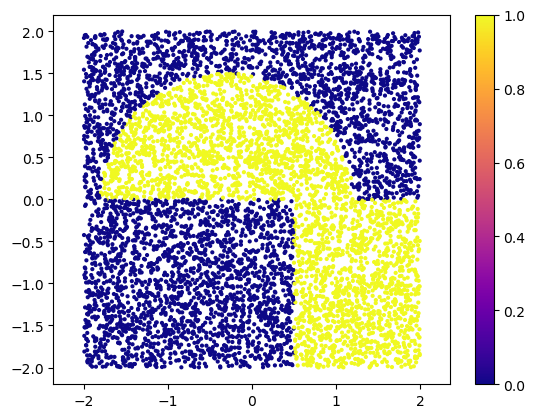

In [3]:
x_train, y_train, x_test, y_test = gen_data(CASE=1, N=10000, N_train=7000)
# plt.figure(figsize=(6,4))
plot_scatter(x_train, y_train)
plt.colorbar()
plt.axis('equal')
plt.show()

## Classifier: XGB

In [4]:
def classify(clf=XGBClassifier(),show=False):
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)

    if CASE<10: print("errors: {:.2f}%".format(100*(1-clf.score(x_test, y_test))))

    dx = 0.02
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,2))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    plt.figure(figsize=(6,6))
    plt.title(str(clf))

    plot_scatter(x_plot,y_plot)
    plot_scatter(x_train,y_train,s=7)
    plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(3,1,figsize=(30, 30))
        for i in range(min(3,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=300, pad_inches=0.02)   
        plt.show()

errors: 0.70%


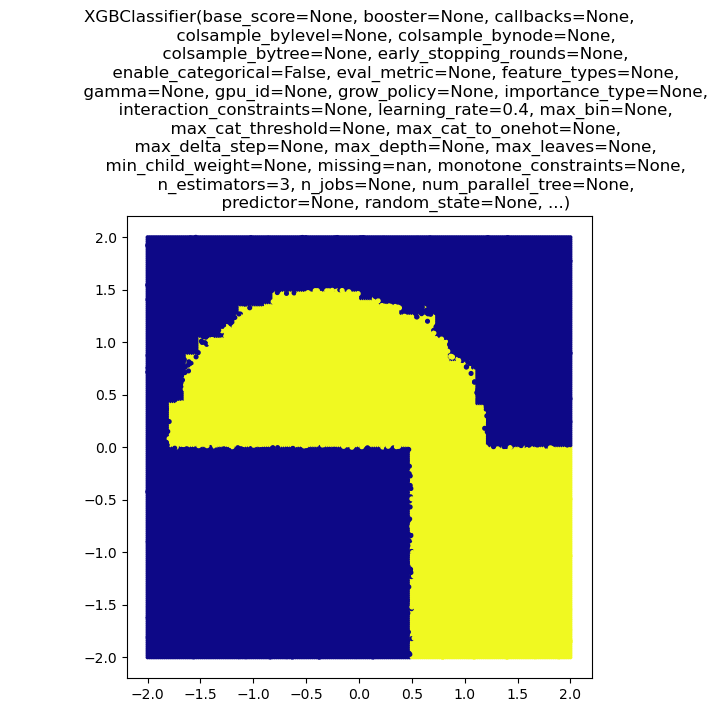

num_trees= 3


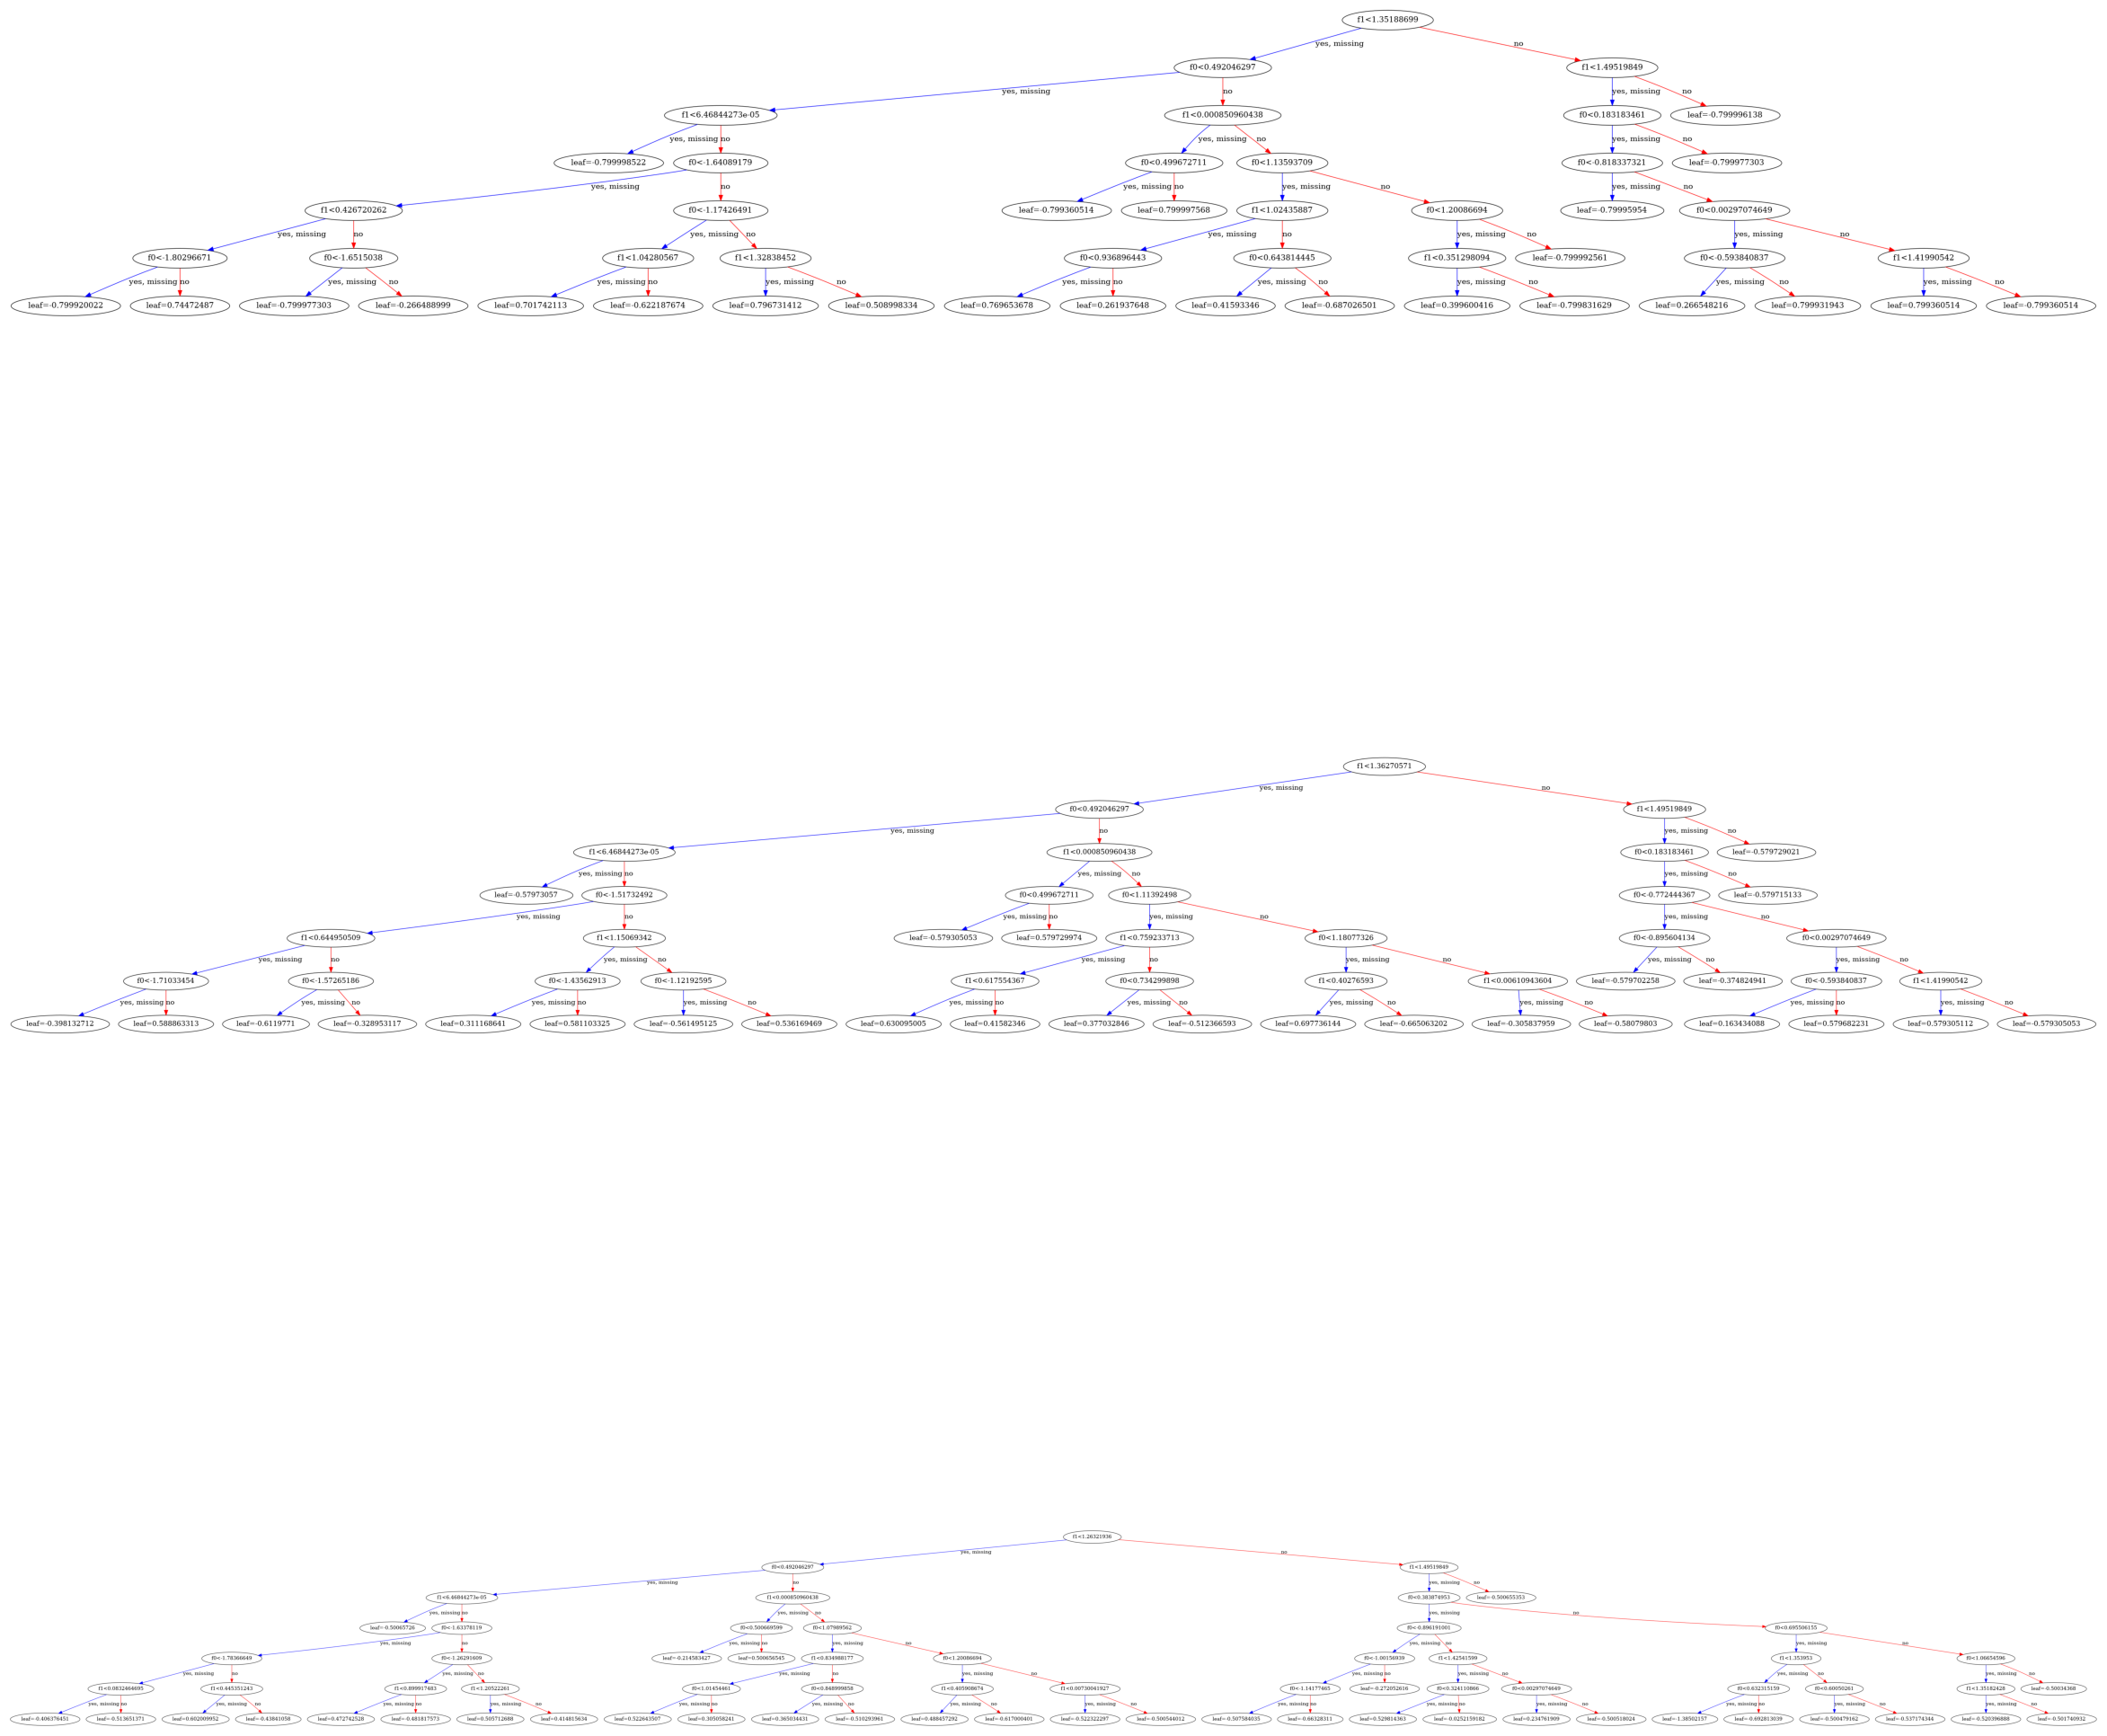

In [5]:
CASE=1
S = 2
classify(XGBClassifier(seed=1,
                       objective='binary:logistic',
                       #objective="reg:squarederror",eval_metric="rmse",
                       learning_rate=0.4,
                       reg_lambda=0.001, n_estimators=3),show=True)

## Classifier NN